In [3]:
# Load libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn import metrics
from sklearn import svm
import datetime
import pandas as pd
import numpy as np
from imblearn.ensemble import BalanceCascade
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import scipy

/Users/disha.gupta1@ibm.com/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
All_Data=pd.read_csv('/Users/disha.gupta1@ibm.com/Desktop/BC Spills/Working/ALL_DATA_BC.csv', header=0)
All_Data_Spills=pd.read_csv('/Users/disha.gupta1@ibm.com/Desktop/BC Spills/Working/VancouverSpillsLatLongFlag.csv', header=0)
All_Data=All_Data.append(pd.DataFrame(data = All_Data_Spills), ignore_index=True)
#for highway avg accidents
All_Data.to_csv("ForHighwayAvgAccidents.csv", sep=',',index=False)
#All_Data["OBSERVATIONTIMEUTCISO"]=All_Data["OBSERVATIONTIMEUTCISO"].astype(str).str.replace("T"," ")

In [5]:
All_Data=All_Data.sort_values(by='OBSERVATIONTIMEUTCISO1')
All_Data['DATE'] = pd.to_datetime(All_Data["DATE"]).dt.date
All_Data['DAY'] = pd.to_datetime(All_Data["DATE"]).dt.day.astype(int)
All_Data['MONTH'] = pd.to_datetime(All_Data["DATE"]).dt.month.astype(int)
All_Data['YEAR'] = pd.to_datetime(All_Data["DATE"]).dt.year.astype(int)
All_Data['YEAR_DAY'] = pd.to_datetime(All_Data["DATE"]).apply(lambda x: x.timetuple().tm_yday)
All_Data.loc[All_Data['WINDGUST'].isnull(),'WINDGUST'] = All_Data['WINDSPEED']
All_Data['BLIZZARD'] = All_Data['SNOW1HOUR']*All_Data['WINDSPEED']*All_Data['WINDSPEED']
All_Data['FOG'] = 0
All_Data.loc[All_Data['VISIBILITY']<=0.25, 'FOG'] = 1 

In [6]:
All_Data_Previous = pd.DataFrame(All_Data[["OBSERVATIONTIMEUTCISO","SNOW1HOUR","PRECIP1HOUR","LATITUDE","LONGITUDE"]])
All_Data_Previous["OBSERVATIONTIMEUTCISO"]=pd.to_datetime(All_Data_Previous["OBSERVATIONTIMEUTCISO"],format="%Y-%m-%d %H:%M:%S")
All_Data["PREVIOUSHOUR"]=pd.to_datetime(All_Data["OBSERVATIONTIMEUTCISO"]).apply(lambda x: x - datetime.timedelta(hours = 1))
All_Data_Previous.columns = ["PREVIOUSHOUR", "SNOW2HOUR","PRECIP2HOUR","LATITUDE","LONGITUDE"]
All_Data = pd.merge(All_Data,All_Data_Previous,on=["PREVIOUSHOUR","LATITUDE","LONGITUDE"],how="left")

In [7]:
def SnowDriftIndex(df):
    snowqpf=df['SNOW1HOUR']
    temperature=df['TEMPERATURE']
    Windspeed=df['WINDSPEED']
    Tc = (temperature-32)*(5/9)
    #Temperature Function
    aT = (1710+13.6*Tc) #remove 10**-9 for scaling purposes
    #Convert mph to M/s
    Windspeedms = Windspeed*.44704
    SDI = snowqpf*(np.power(Windspeedms,2)/aT)
    #if temperature is greater than or equal to 40F no drifting will occur
    SDI = np.array(SDI)
    SDI[Tc>4] = 0
    SDI = np.array(SDI)
    SDI[SDI>1] = 1
    SDI = np.array(SDI)
    SDI[Windspeedms<8] = 0
    #Threshold = aT/(np.power(Windspeedms,2)/aT) * .5
    return SDI

def BlackIceIndex(df):
    qpf=df['PRECIP1HOUR']
    snowqpf=df['SNOW1HOUR']
    temperature=df['TEMPERATURE']
    Windspeed=df['WINDSPEED']
    TEMPERATUREFEELSLIKE=df['TEMPERATUREFEELSLIKE']
    rh=df['RELATIVEHUMIDITY']
    DayPeriod = np.where(df['HOUR']>21, 'N', 'D')
    bool = ((qpf>0) & (TEMPERATUREFEELSLIKE<32) & 
            (snowqpf==0)) | ((temperature<32) & (TEMPERATUREFEELSLIKE<32) & (rh>95) & (DayPeriod=="N") &
                             (Windspeed<5) & (qpf==0))
    BlackIce = 1*bool
    return BlackIce

In [8]:
All_Data['SNOWDRIFTINDEX']=All_Data.apply(SnowDriftIndex, axis=1)
All_Data['BLACKICEINDEX']=All_Data.apply(BlackIceIndex, axis=1)

In [9]:
All_Data['WeatherFlag']=All_Data['Flag']
All_Data.loc[(All_Data['PRECIP1HOUR']==0) &
             (All_Data['PRECIP2HOUR']==0) &
             (All_Data['SNOW2HOUR']==0) &
             (All_Data['SNOW1HOUR']==0) &
             (All_Data['VISIBILITY']>0.3) &
             (All_Data['WINDGUST']<35),'WeatherFlag']=0

In [10]:
#print(All_Data.groupby("WeatherFlag").DATE.count())
All_Data['Flag']=All_Data['WeatherFlag']
print(All_Data.groupby("Flag").DATE.count())

Flag
0.0     219488
1.0         10
2.0        108
4.0         98
6.0         50
8.0         30
10.0        24
12.0         8
14.0         7
16.0         6
18.0         4
20.0         3
22.0         2
24.0         2
26.0         1
30.0         1
32.0         1
40.0         1
42.0         1
44.0         1
Name: DATE, dtype: int64


In [11]:
All_Data['Flag']=(All_Data['Flag']>=1).astype(int)

In [12]:
#All_Data.isnull().sum(axis=0)

In [29]:
columns = ['DATE',"LATITUDE","LONGITUDE",'PRECIP1HOUR',
       'PRESSURECHANGE', 'RELATIVEHUMIDITY', 'SNOW1HOUR', 'TEMPERATURE',
       'TEMPERATUREDEWPOINT', 'TEMPERATUREFEELSLIKE',
        'UVINDEX', 'VISIBILITY','SNOWDRIFTINDEX','BLACKICEINDEX',
       'WINDSPEED','WINDGUST','BLIZZARD','FOG', "NonWeatherRisk",'HOUR','YEAR_DAY','MONTH','PRECIP2HOUR','SNOW2HOUR','Flag']

df=All_Data[columns]

In [30]:
#df1=df.fillna(method='ffill', inplace = True)

In [32]:
sin_HOUR = np.zeros(len(df))
cos_HOUR = np.zeros(len(df))
sin_YEAR_DAY = np.zeros(len(df))
cos_YEAR_DAY = np.zeros(len(df))
sin_MONTH = np.zeros(len(df))
cos_MONTH = np.zeros(len(df))
for i in range(len(df)):
    sin_HOUR[i] = np.sin(((df['HOUR'][i]/24)*np.pi)/2)
    cos_HOUR[i] = np.sin(((df['HOUR'][i]/24)*np.pi)/2)
    sin_YEAR_DAY[i] = np.sin(((df['YEAR_DAY'][i]/365)*np.pi)/2)
    cos_YEAR_DAY[i] = np.sin(((df['YEAR_DAY'][i]/365)*np.pi)/2)
    sin_MONTH[i] = np.sin(((df['MONTH'][i]/12)*np.pi)/2)
    cos_MONTH[i] = np.sin(((df['MONTH'][i]/12)*np.pi)/2)

df=pd.DataFrame(df)
df['sin_HOUR'] = sin_HOUR
df['cos_HOUR'] = cos_HOUR

df['sin_YEAR_DAY'] = sin_YEAR_DAY
df['cos_YEAR_DAY'] = cos_YEAR_DAY

df['sin_MONTH'] = sin_MONTH
df['cos_MONTH'] = cos_MONTH

In [48]:
#Few values with NA for flag = 1, overall few too, drop na instead of imputing?
df=df.dropna()

In [49]:
print(df.groupby("Flag").DATE.count())

Flag
0    211237
1       326
Name: DATE, dtype: int64


In [50]:
features = ['PRECIP1HOUR', 'RELATIVEHUMIDITY', 'SNOW1HOUR', 'TEMPERATURE',
       'TEMPERATUREDEWPOINT', 'TEMPERATUREFEELSLIKE', 'VISIBILITY','SNOWDRIFTINDEX','BLACKICEINDEX',
       'WINDSPEED','WINDGUST','BLIZZARD','FOG', "NonWeatherRisk", 'sin_HOUR','cos_HOUR','sin_YEAR_DAY','cos_YEAR_DAY',
            'sin_MONTH','cos_MONTH','PRECIP2HOUR','SNOW2HOUR']
df_features = df[features]

In [51]:
# create X and target vector y
#X = df_features
X = df
y = df['Flag']
X_train, X_test_final, y_train, y_test_final = train_test_split(X, y, test_size=0.20)

In [52]:
#Should stratify the test set of CV too, before resampling: http://www.alfredo.motta.name/cross-validation-done-wrong/
def stratified_rf(X_train, y_train,n_folds=2,max_features="sqrt",n_estimators=500,leaf_size=20):
    kf = cross_validation.StratifiedKFold(y_train, n_folds=n_folds)
    fold_count = 0
    accuracy = pd.Series()
    recall = pd.Series()
    precision = pd.Series()
    actual = pd.Series()
    prediction_prob = pd.Series()
    prediction_actual = pd.Series()
    test_features = pd.DataFrame()
    for train, test in kf:
        print("Processing fold %s" % fold_count)
        X_train_fold_all = X_train.iloc[train]
        X_test_fold_all = X_train.iloc[test]
        y_train_fold = y_train.iloc[train]
        y_test_fold = y_train.iloc[test]
        y_train_fold = np.array(y_train_fold,dtype=np.int8)
        features = ['PRECIP1HOUR', 'RELATIVEHUMIDITY', 'SNOW1HOUR', 'TEMPERATURE',
       'TEMPERATUREDEWPOINT', 'TEMPERATUREFEELSLIKE', 'VISIBILITY','SNOWDRIFTINDEX','BLACKICEINDEX',
       'WINDSPEED','WINDGUST','BLIZZARD','FOG', "NonWeatherRisk", 'sin_HOUR','cos_HOUR','sin_YEAR_DAY','cos_YEAR_DAY',
            'sin_MONTH','cos_MONTH','PRECIP2HOUR','SNOW2HOUR']
        X_train_fold=X_train_fold_all[features]
        X_test_fold=X_test_fold_all[features]
        #Do resampling on training, not on testing
        bc = BalanceCascade()
        X_resampled, y_resampled = bc.fit_sample(X_train_fold, y_train_fold)
        X_resampled=X_resampled.reshape(1, X_resampled.shape[0]*X_resampled.shape[1], -1)
        y_resampled=y_resampled.reshape(1, y_resampled.shape[0]*y_resampled.shape[1], -1)
        
        X_train_fold = pd.DataFrame(data=X_resampled[0],columns=X_train_fold.columns)
        y_train_fold = y_resampled[0]
        
        #Train the model
        clf = RandomForestClassifier(n_jobs=-1, random_state=0,max_features=max_features,n_estimators=n_estimators,
                                   max_depth=5,class_weight={0:1,1:1.1})
        #kernel = 'linear'
        #clf = svm.SVC(kernel=kernel, gamma=2)
        clf.fit(X_train_fold, y_train_fold.ravel())
        
        #Make predictions
        y_pred_fold=clf.predict(X_test_fold)
        y_pred_proba = clf.predict_proba(X_test_fold)[::,1]
        
        #Get accuracy, recall and precision
        accuracy = recall.append(pd.Series(metrics.accuracy_score(y_test_fold, y_pred_fold)))
        recall = recall.append(pd.Series(metrics.recall_score(y_test_fold, y_pred_fold)))
        precision = precision.append(pd.Series(metrics.precision_score(y_test_fold, y_pred_fold)))
        prediction_prob = prediction_prob.append(pd.Series(y_pred_proba))
        prediction_actual = prediction_actual.append(pd.Series(y_pred_fold))
        actual = actual.append(pd.Series(y_test_fold))
        test_features = test_features.append(X_test_fold_all)
        # Done with the fold
        fold_count += 1
    
    return recall, precision, accuracy, prediction_prob, prediction_actual, actual, test_features
        

In [61]:
#recall, precision, accuracy, prediction_prob, prediction_actual, actual = stratified_rf(X_train, y_train,n_folds=2,max_features="sqrt",n_estimators=1000)
recall, precision, accuracy, prediction_prob, prediction_actual, actual, test_features = stratified_rf(X, y,n_folds=5,max_features="log2",n_estimators=500)
print("Recall: %s" % pd.DataFrame(recall).mean())
print("Precision: %s" % pd.DataFrame(precision).mean())
print("Accuracy: %s" % pd.DataFrame(accuracy).mean())

Processing fold 0
Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Recall: 0    0.794499
dtype: float64
Precision: 0    0.011442
dtype: float64
Accuracy: 0    0.783206
dtype: float64


[[184683  26554]
 [    67    259]]
             precision    recall  f1-score   support

          0       1.00      0.87      0.93    211237
          1       0.01      0.79      0.02       326

avg / total       1.00      0.87      0.93    211563



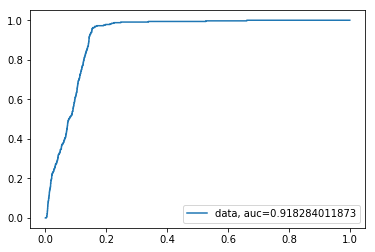

In [62]:
print(metrics.confusion_matrix(actual,prediction_actual))
print(metrics.classification_report(actual, prediction_actual))
min_max_scaler = preprocessing.MinMaxScaler()
y_pred_proba_scaled = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(prediction_prob).values))[0]
#y_pred_proba_scaled=prediction_prob
fpr, tpr, threshold = metrics.roc_curve(actual, y_pred_proba_scaled)
auc = metrics.roc_auc_score(actual, y_pred_proba_scaled)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [75]:
print(min(prediction_prob))
print(max(prediction_prob))

0.04122591759555907
0.9268199181302602


In [65]:
results = pd.concat([pd.DataFrame(test_features).reset_index(drop=True), pd.DataFrame({'Risk Probability':prediction_prob}).reset_index(drop=True), pd.DataFrame({'Normalized Risk Probability':y_pred_proba_scaled}).reset_index(drop=True),pd.DataFrame({'Actual Risk Flag':actual}).reset_index(drop=True)], axis=1)
results.to_csv("Predictions NonWeather.csv", sep=',',index=False)
#results

In [ ]:
f1=0
threshold = 0
for i in np.linspace(start=0, stop=0.6, num=100):
    prediction_actual_update = np.where(prediction_prob>=i, 1, 0)
    if(metrics.roc_auc_score(actual, prediction_actual_update)>f1):
        f1=metrics.roc_auc_score(actual, prediction_actual_update)
        threshold = i
print("roc_auc: ",f1,"Threshold: ", threshold)
prediction_THRESHOLD = np.where(prediction_prob>=threshold, 1, 0)
print(metrics.confusion_matrix(actual,prediction_THRESHOLD))
print(metrics.classification_report(actual, prediction_THRESHOLD))
print("Accuracy", metrics.accuracy_score(actual, prediction_THRESHOLD))
print("Recall", metrics.recall_score(actual, prediction_THRESHOLD))
print("Precision", metrics.precision_score(actual, prediction_THRESHOLD))

In [ ]:
# Create a random forest Classifier on the complete training dataset
bc = BalanceCascade()
X_train = df_features
y_train = df['Flag']
y_train = np.array(y_train,dtype=np.int8)
X_resampled, y_resampled = bc.fit_sample(X_train, y_train)
X_resampled=X_resampled.reshape(1, X_resampled.shape[0]*X_resampled.shape[1], -1)
y_resampled=y_resampled.reshape(1, y_resampled.shape[0]*y_resampled.shape[1], -1)
        
X_train_resampled = pd.DataFrame(data=X_resampled[0],columns=X_train.columns)
y_train_resampled = y_resampled[0]
clf = RandomForestClassifier(n_jobs=-1, random_state=0,max_features="log2",n_estimators=1000,
                            max_depth=5,class_weight={0:1,1:1.1})
clf.fit(X_train_resampled, y_train_resampled.ravel())
predRF=clf.predict(X_test_final)
predRF_proba = clf.predict_proba(X_test_final)[::,1]
print("Accuracy", metrics.accuracy_score(y_test_final, predRF))
print("Recall", metrics.recall_score(y_test_final, predRF))
print(metrics.confusion_matrix(y_test_final,predRF))
print(metrics.classification_report(y_test_final, predRF))

#changed threshold
prediction_THRESHOLD = np.where(predRF_proba>=threshold, 1, 0)
print(metrics.confusion_matrix(y_test_final,prediction_THRESHOLD))
print("Accuracy", metrics.accuracy_score(y_test_final, prediction_THRESHOLD))
print("Recall", metrics.recall_score(y_test_final, prediction_THRESHOLD))
print("Precision", metrics.precision_score(y_test_final, prediction_THRESHOLD))

In [71]:
# FINAL MODEL on COMPLETE DATA
bc = BalanceCascade()
X = df_features
y = np.array(y,dtype=np.int8)
X_resampled, y_resampled = bc.fit_sample(X, y)
X_resampled=X_resampled.reshape(1, X_resampled.shape[0]*X_resampled.shape[1], -1)
y_resampled=y_resampled.reshape(1, y_resampled.shape[0]*y_resampled.shape[1], -1)
        
X_resampled = pd.DataFrame(data=X_resampled[0],columns=X.columns)
y_resampled = y_resampled[0]
clf = RandomForestClassifier(n_jobs=-1, random_state=0,max_features="log2",n_estimators=1000,
                            max_depth=5,class_weight={0:1,1:1.1})
clf.fit(X_resampled, y_resampled.ravel())

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1.1},
            criterion='gini', max_depth=5, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [74]:
# save the model to disk
filename = 'MC-UnderSampled-RandomForest-NonWeatherFeature.sav'
joblib.dump(clf, filename)

# load the model from disk
#loaded_model = joblib.load(filename)
#result = loaded_model.score(X_test, Y_test)
#print(result)

['MC-UnderSampled-RandomForest-NonWeatherFeature.sav']

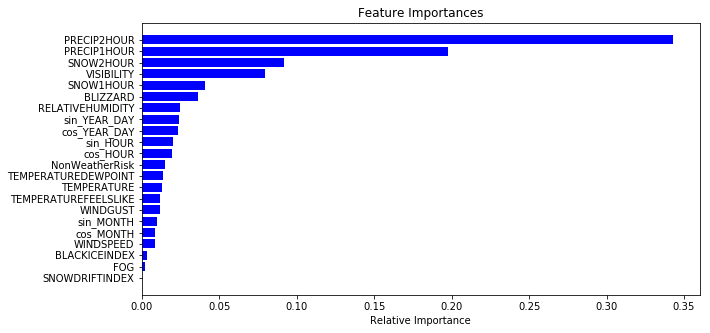

In [72]:
features = df_features.columns.values
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.rcParams['figure.figsize'] = [10, 5]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()



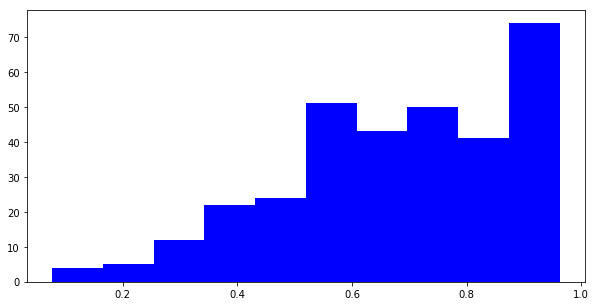

In [86]:
num_bins = 10
x=results[results["Actual Risk Flag"]==1]
x=x['Normalized Risk Probability']
n, bins, patches = plt.hist(x, num_bins, facecolor='blue')
plt.show()

In [87]:
bins

array([ 0.07728368,  0.16577867,  0.25427367,  0.34276866,  0.43126365,
        0.51975865,  0.60825364,  0.69674864,  0.78524363,  0.87373863,
        0.96223362])

In [66]:
results["Prediction"] = 0
results.loc[(results['Normalized Risk Probability']>0.95),"Prediction"]=1
city = results[(round(results["LATITUDE"],0)==48) & (round(results["LONGITUDE"],0)==-123)]
rural = results[(round(results["LATITUDE"],0)==50) & (round(results["LONGITUDE"],0)==-125)]
city.groupby(["HOUR"]).Flag.sum()
city.groupby(["HOUR"]).max()['Normalized Risk Probability']

HOUR
0     0.805852
1     0.746834
2     0.752618
3     0.740791
4     0.851795
5     0.839847
6     0.790753
7     0.917382
8     0.967907
9     0.952579
10    0.950326
11    0.946182
12    0.951114
13    0.952688
14    0.961919
15    0.962715
16    0.959388
17    0.929524
18    0.915157
19    0.911121
20    0.905686
21    0.893752
22    0.910023
23    0.903779
Name: Normalized Risk Probability, dtype: float64

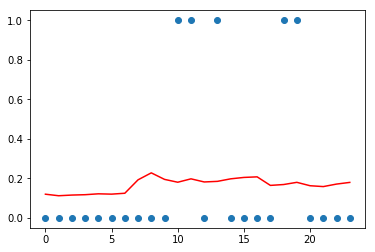

In [67]:
from numpy import *
import math
import matplotlib.pyplot as plt

t = linspace(0, 23, 24)

plt.plot(t, city.groupby(["HOUR"]).mean()['Normalized Risk Probability'], 'r') # plotting t, a separately 
#plt.plot(t, city.groupby(["HOUR"]).max()['Normalized Risk Probability'], 'b') # plotting t, a separately 
#plt.plot(t, city.groupby(["HOUR"]).Flag.mean(), 'g') # plotting t, c separately 
plt.plot(t, city.groupby(["HOUR"]).Flag.max(), 'o') # plotting t, a separately 
plt.show()

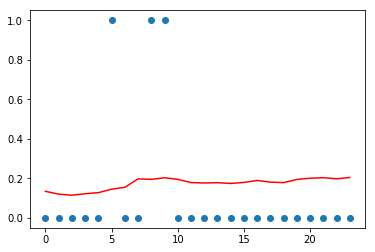

In [68]:
from numpy import *
import math
import matplotlib.pyplot as plt

t = linspace(0, 23, 24)

plt.plot(t, rural.groupby(["HOUR"]).mean()['Normalized Risk Probability'], 'r') # plotting t, b separately 
#plt.plot(t, rural.groupby(["HOUR"]).max()['Normalized Risk Probability'], 'm') # plotting t, b separately 
#plt.plot(t, rural.groupby(["HOUR"]).Flag.mean(), 'g') # plotting t, c separately 
plt.plot(t, rural.groupby(["HOUR"]).Flag.max(), 'o') # plotting t, a separately 

plt.show()